In [6]:
using FeedbackParticleFilters

using StatsBase
using LinearAlgebra
using PyPlot
using Profile

# Single gain computation

In [1]:
# numerical integral over R by transform
function finv(y::Float64)
    return tan(pi*y/2)#log((1+y)/(1-y))
end

function finvprime(y::Float64)
    return pi/(1+cos(pi*y))#2/(1-y^2)
end

function NumIntR(fun::Function, n::Int64)
    x = zeros(Float64, n+1)
    int = zeros(Float64, n+1)
    dy = 2. / (n+1)
    y = -1. -dy/2
    for i = 2:(n+1)
        y = y + dy
        x[i] = finv(y)
        int[i] = int[i-1] + fun(x[i]) * dy * finvprime(y)
    end
    x[2:n+1], int[2:n+1]
end;

In [9]:
# Settings
function p(x::Float64)
    ( exp(-(x-1)^2/(2*0.16))+exp(-(x+1)^2/(2*0.16)) ) / sqrt(8*pi*0.16)
end;

h(x) = x

h (generic function with 2 methods)

In [3]:
hbar = NumIntR(x -> h(x)*p(x),1000)[2][end]

-6.876696392728779e-16

In [4]:
xx,int = NumIntR(x -> -(h(x)-hbar)*p(x),1000);
K_exact = int ./ p.(xx);

In [16]:
N=1000
positions=hcat(0.4.*randn(1,div(N,2)).-1,0.4.*randn(1,div(N,2)).+1)
testens=UnweightedParticleEnsemble(positions);
eq=PoissonEquation(h, testens)

Poisson equation for the gain
    # of particles:        1000
    hidden dimension:      1
    observed dimension:    1

In [24]:
@time solve!(eq, SemigroupMethod(0.1,1E-2));

  0.021553 seconds (35 allocations: 15.314 MiB, 8.38% gc time)


In [22]:
@time update!(eq, testens);

  0.000361 seconds (6.52 k allocations: 174.172 KiB)


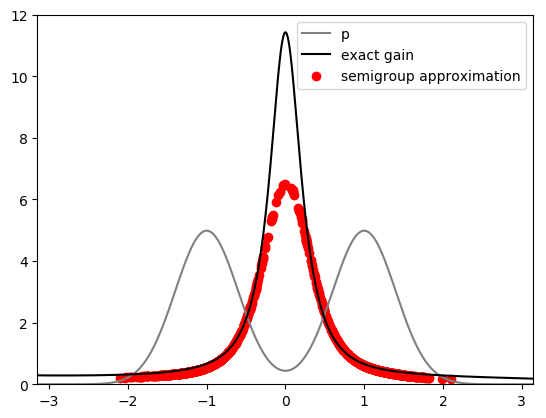

In [25]:
xlim((1.5*minimum(testens.positions),1.5*maximum(testens.positions)))
ylim((0,12))
plot(xx, 10*p.(xx), color="gray");
plot(xx, K_exact, color="black");
scatter(eq.positions, eq.gain, color="red");
#scatter(testens.positions, testens.potential)
#hist(testens.positions,50)
legend(("p","exact gain","semigroup approximation"));

# Loop

In [26]:
function applygain!(ens::UnweightedParticleEnsemble, eq::GainEquation, dt::Real)
    for i in 1:obs_dim(eq)
        ens.positions .+= view(eq.gain, :, :, i) * dt
    end
end

applygain! (generic function with 1 method)

In [32]:
@time applygain!(testens, eq, 1E-2)

  0.000009 seconds (6 allocations: 8.156 KiB)


In [38]:
# simulate sequential gain estimation and update
N=1000
positions=hcat(0.4.*randn(1,div(N,2)).-1,0.4.*randn(1,div(N,2)).+1)
testens=UnweightedParticleEnsemble(positions);
eq=PoissonEquation(h, testens);
n_time = 100 # number of time steps
positions = zeros(n_time,N)
potentials = zeros(n_time,N)
gains = zeros(n_time,N)
@timev for i = 1:n_time
    update!(eq, testens)
    solve!(eq, SemigroupMethod(0.1,0.01))
    positions[i,:] = view(testens.positions, 1, :)
    #testens.gain_data.potential = eq.potential
    #testens.gain_data.gain = eq.gain
    potentials[i,:] = view(eq.potential, 1, :)
    gains[i,:] = view(eq.gain, 1, :, 1)
    applygain!(testens, eq, 1E-2)
end

  1.654215 seconds (660.97 k allocations: 1.521 GiB, 8.21% gc time)
elapsed time (ns): 1654214742
gc time (ns):      135806685
bytes allocated:   1632653564
pool allocs:       658881
non-pool GC allocs:1888
malloc() calls:    200
GC pauses:         67
full collections:  1


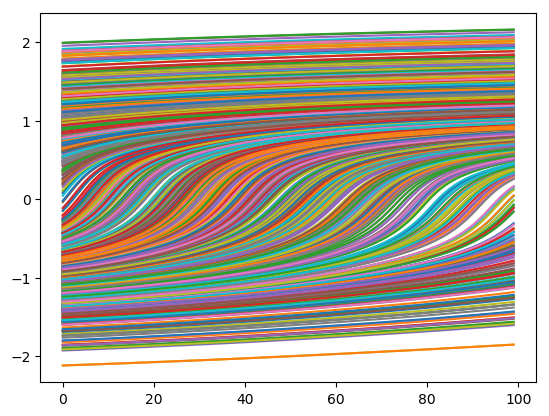

In [39]:
plot(positions[:,:]);

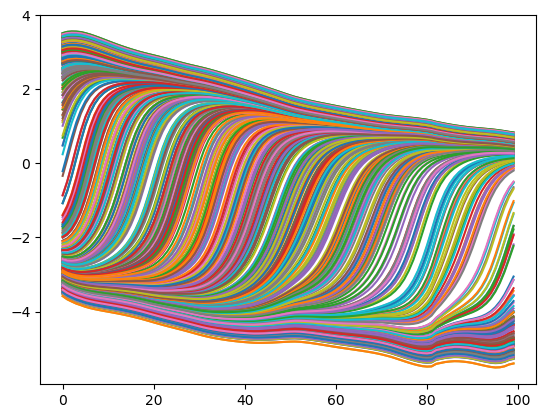

In [40]:
plot(potentials[:,:]);

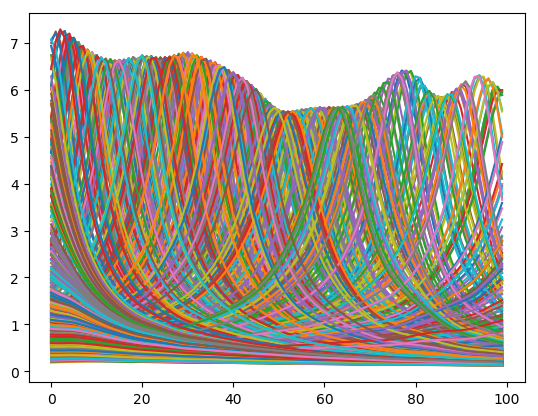

In [41]:
plot(gains[:,:]);